
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Monthly Mean Sea Level using a multivariate-linear regression model based on the annual SST PCs

inputs required: 
  * Parameters of the linear regression between MMSLA and annual PCs (from Notebook 01_Offshore/02_TIDES_MMSL_Regression) 
  * Simulated Annual SST PCs under climate change (from Notebook 01_01_AWTs_Probability_Change)

in this notebook:
  * Obtain predicted timeseries of MMSLA based on simulated timeseries of annual PCs (affected by climate change)
  

In [1]:
 #!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
from collections import OrderedDict

# python libs
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.util.time_operations import date2yearfrac as d2yf
from teslakit.io.aux_nc import StoreBugXdset

from teslakit.plotting.tides import Plot_MMSL_Histogram, Plot_MMSL_Prediction, Plot_Validate_MMSL_scatter



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database
p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
# offshore
db = Database(p_data)
db.SetSite('GUAM')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('GUAM_CC_S5')


In [4]:
 # --------------------------------------
# load data and set parameters

SST_PCs_sim_m = db_S5.Load_SST_PCs_sim_m()  # climate change simulated SST PCs (monthly)
params_sim = db.Load_TIDE_mmsl_params()       # MMSL non linear regress model coef 

MMSL_hist = db.Load_TIDE_hist_mmsl() # MMSL historical values (for plotting comparison)
MMSL_sim = db.Load_TIDE_sim_mmsl() # MMSL simulation without climate change (for plotting comparison)



## Monthly Mean Sea Level - Multivariate-linear Regression Model

In [6]:

def modelfun(data, *x):
    pc1, pc2, pc3, t = data
    
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            np.array([x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3]).flatten() * np.cos(2*np.pi*t) + \
            np.array([x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3]).flatten() * np.sin(2*np.pi*t) + \
            np.array([x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3]).flatten() * np.cos(4*np.pi*t) + \
            np.array([x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3]).flatten() * np.sin(4*np.pi*t) 



## Monthly Mean Sea Level - Prediction

In [7]:
 # --------------------------------------
# Predict 1000 years using simulated PCs (monthly time resolution)

# get simulation time as year fractions
PCs_sim_time = SST_PCs_sim_m.time.values[:]
frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])

# solve each PCs simulation
y_sim_n = np.ndarray((len(SST_PCs_sim_m.n_sim), len(frac_year_sim))) * np.nan
for s in SST_PCs_sim_m.n_sim:
    
    PCs_s_m = SST_PCs_sim_m.sel(n_sim=s)
    MMSL_PC1_sim = PCs_s_m.PC1.values[:]
    MMSL_PC2_sim = PCs_s_m.PC2.values[:]
    MMSL_PC3_sim = PCs_s_m.PC3.values[:]
    
    # use linear-regression model
    x_sim = ([MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim, frac_year_sim])
    y_sim_n[s, :] = modelfun(x_sim, *params_sim.sim_params.sel(n_sims=s).values)


# join output and store it
MMSL_sim_CC_S5 = xr.Dataset(
    {
        'mmsl' : (('n_sim','time'), y_sim_n / 1000),  # mm to m
    },
    {'time' : PCs_sim_time}
)
print(MMSL_sim_CC_S5)

db_S5.Save_TIDE_sim_mmsl(MMSL_sim_CC_S5)

<xarray.Dataset>
Dimensions:  (n_sim: 100, time: 12012)
Coordinates:
  * time     (time) object 1999-06-01 00:00:00 ... 3000-05-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    mmsl     (n_sim, time) float64 0.07254 0.09483 0.1167 ... 0.07119 0.07603


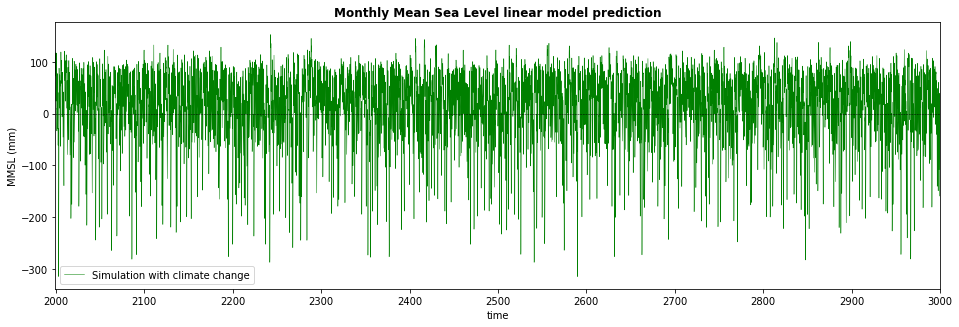

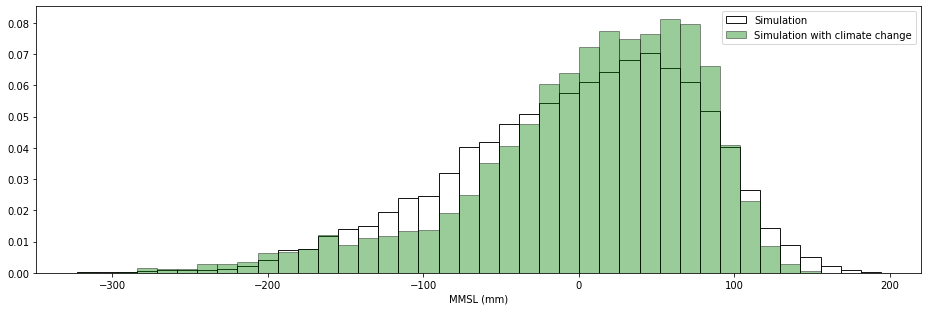

In [8]:
# Plot mmsl simulation 

plot_sim = 0

y_sim_CC_S5 = MMSL_sim_CC_S5.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm
t_sim = MMSL_sim_CC_S5.sel(n_sim=plot_sim).time.values[:]

y_sim = MMSL_sim.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm


# Plot mmsl prediction
Plot_MMSL_Prediction(t_sim, y_sim_CC_S5, label='Simulation with climate change');


# compare model histograms
Plot_MMSL_Histogram(y_sim, y_sim_CC_S5, label_1='Simulation', label_2='Simulation with climate change');



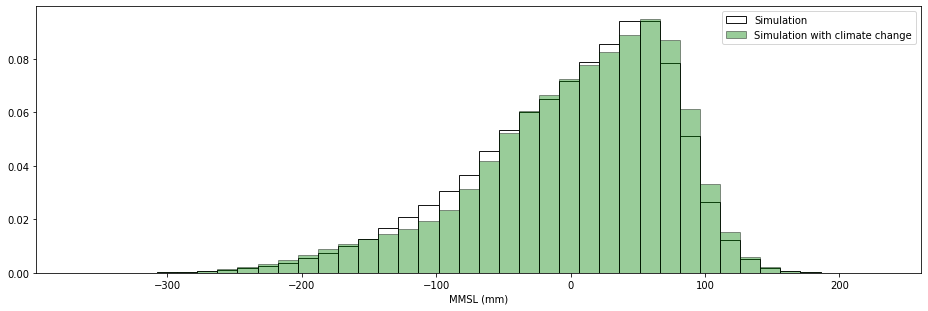

In [9]:
# compare model histograms for all simulations

y_sim = MMSL_sim.mmsl.values[:].flatten() * 1000  # m to mm
y_sim_CC_S5 = MMSL_sim_CC_S5.mmsl.values[:].flatten() * 1000  # m to mm

Plot_MMSL_Histogram(y_sim, y_sim_CC_S5, label_1='Simulation', label_2='Simulation with climate change');


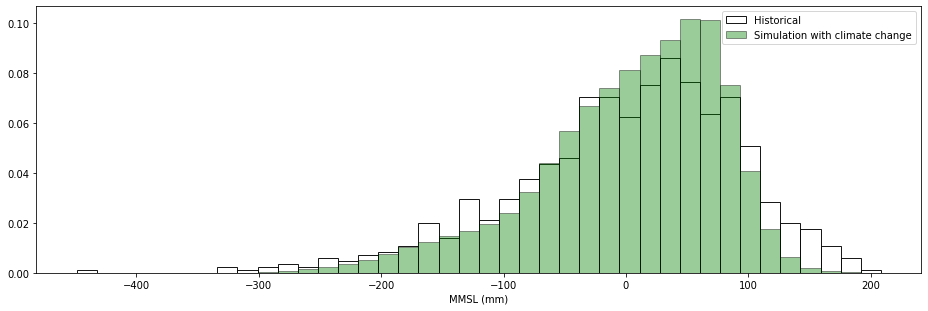

In [10]:
# compare model histograms for all simulations with historical values

Plot_MMSL_Histogram(MMSL_hist.mmsl, y_sim_CC_S5, label_1='Historical', label_2='Simulation with climate change');
